# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

2024-11-04 12:24:03.604484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 12:24:03.628536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 12:24:03.635843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 12:24:04.999431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Input data - dropping date and bitcoin opening, high and low prices

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data = data.drop(columns=['Date'])

In [4]:
data.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),Mean Hash Rate,...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,356031.3023,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,420413.4050,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,372000.7193,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,437493.8037,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,424395.1868,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [5]:
data.shape

(2430, 47)

In [6]:
data.isna().sum()

BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY                            0
EUR       

# Split data into train and test set

In [7]:
# Define train size, test size = 1 - train size
train_size = int(len(data) * 0.8)
train_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_set
X_test = test_set

# Create the target sets
Y_train = train_set[target]
Y_test = test_set[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

ts = 1 # Define the time step
# Create sequences with a time step defined by ts
def create_sequences(data, target, time_step=ts):
	X, y = [], []
	for i in range(len(data) - time_step):
		X.append(data[i:(i + time_step)])
		y.append(target[i + time_step])
	return np.array(X), np.array(y)

X_train, Y_train = create_sequences(X_train.values, Y_train.values)
X_test, Y_test = create_sequences(X_test.values, Y_test.values)

print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("Y_train shape after sequencing:", Y_train.shape)
print("Y_test shape after sequencing:", Y_test.shape)

X_train shape: (1944, 47)
X_test shape: (486, 47)
Y_train shape: (1944,)
Y_test shape: (486,)
X_train shape after sequencing: (1943, 1, 47)
X_test shape after sequencing: (485, 1, 47)
Y_train shape after sequencing: (1943,)
Y_test shape after sequencing: (485,)


# Normalize data with MinMaxScaler

In [9]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(X_train) 

[[[0.00356452 0.00272224 0.00409059 ... 1.         0.         0.        ]]

 [[0.00361647 0.00269888 0.0032567  ... 0.         1.         0.        ]]

 [[0.00264968 0.00204816 0.00324381 ... 0.         0.         1.        ]]

 ...

 [[0.87735389 0.88747437 0.89009328 ... 0.         1.         0.        ]]

 [[0.9088451  0.90910737 0.92463288 ... 0.         0.         1.        ]]

 [[0.93265356 0.98289574 0.957614   ... 0.         0.         0.        ]]]


# Model initialization & compilation

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
	tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.3),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
	tf.keras.layers.Dropout(0.4),
	tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
	tf.keras.layers.Dropout(0.5),
	tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1730697847.272504  191269 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730697847.311033  191269 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730697847.311335  191269 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See 

# Fit train set with label using LSTM model, predict & visualization

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, Y_train, epochs=30, callbacks=[early_stopping])

Epoch 1/30


I0000 00:00:1730697855.123250  191394 service.cc:146] XLA service 0x7f7cc800f260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730697855.123307  191394 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-04 12:24:15.299203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-04 12:24:16.304756: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


37/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49705960.0000 - mae: 5575.9072 - mse: 49673904.0000

I0000 00:00:1730697861.224345  191394 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 48570184.0000 - mae: 5471.0874 - mse: 48570184.0000
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6034147.5000 - mae: 2018.9984 - mse: 6034147.5000
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2269223.7500 - mae: 1137.9126 - mse: 2269223.7500
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1793002.3750 - mae: 929.0402 - mse: 1793002.3750
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1618786.1250 - mae: 845.6436 - mse: 1618786.1250
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1567770.8750 - mae: 814.8295 - mse: 1567770.8750
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1567358.3750 - mae: 832.4074 - mse: 1567358.3750
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1650972.3750 - mae: 855.2237 - mse: 1650972.3750
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1479238.7500 - mae: 797.2627 - mse: 1479238.7500
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s

In [12]:
# Use the model to make predictions on the test set
predictions = model.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(Y_test, predictions)
print("R^2 score:", r2)
# RMSE
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(Y_test, predictions)
print("RMSE:", rmse)

# Directional Accuracy
def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

da = directional_accuracy(Y_test, predictions)



16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
R^2 score: 0.5513096635927592
RMSE: 7100.673844325559


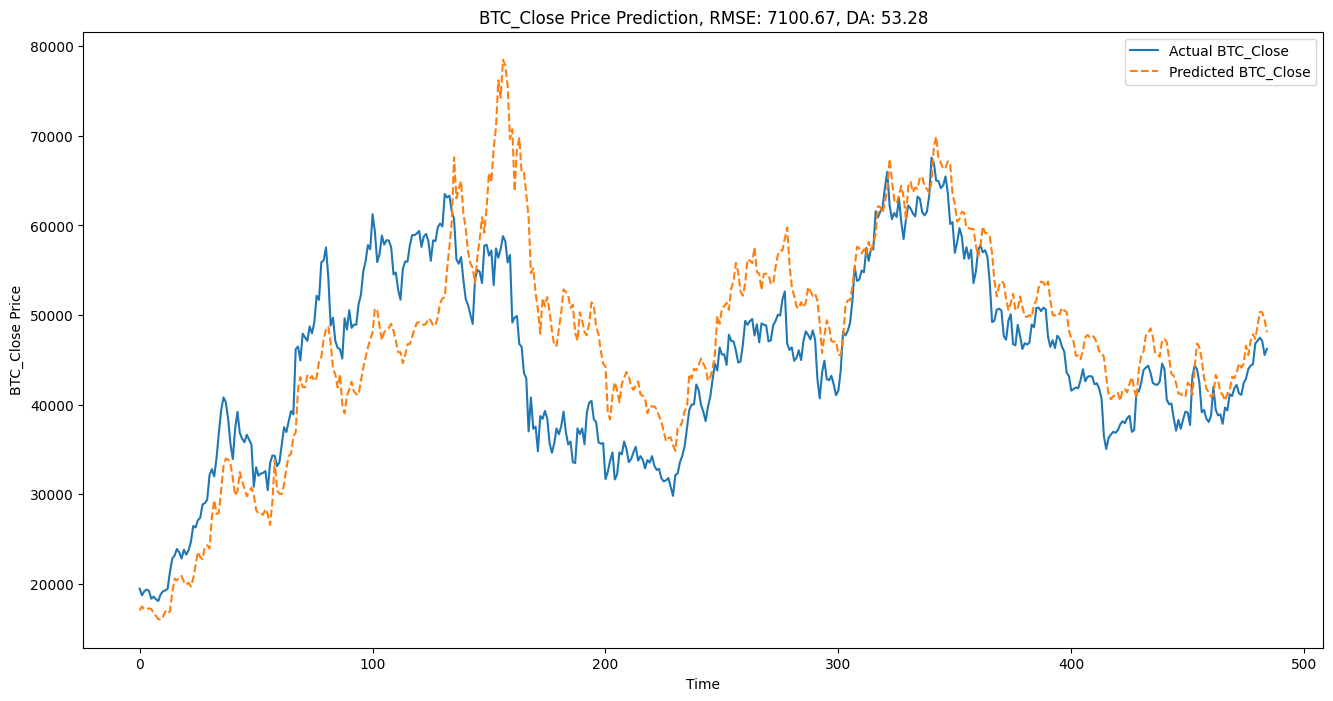

In [13]:
# Plot the predictions against the actual values
plt.figure(figsize=(16, 8))
plt.plot(Y_test, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction, RMSE: {:.2f}, DA: {:.2f}'.format(rmse, da))
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()